# Deep Q-Networks in action: DQN on Atari Breakout 

Train a Deep Q-Network (DQN) agent (experience replay + target network).

In [1]:
# If needed, uncomment these lines:
#!pip -q install "gymnasium[atari,accept-rom-license]"
#!pip -q install "stable-baselines3[extra]"


In [2]:
#!pip install "autorom[accept-rom-license]"


In [7]:
#!pip install -U "gymnasium[atari]" ale-py


Gymnasium’s Atari docs explain the ROM installation flow (AutoROM) and why the extra step is needed. 
Stable-Baselines3 provides `make_atari_env()` which applies standard Atari preprocessing + vectorization.


In [12]:
import os, random, math, time
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
import ale_py


from IPython.display import display, HTML, Video


Atari v5 environment


In [10]:
# Optional: display a reference GIF (online)
from IPython.display import Image
display(Image(url="https://stable-baselines3.readthedocs.io/en/master/_images/breakout.gif"))


obs type: <class 'numpy.ndarray'> obs shape: (210, 160, 3)
rendered frame: (210, 160, 3) uint8


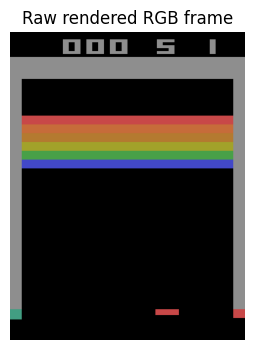

In [15]:
# Create a *visual* env (RGB frames) just for inspection
env_id = "ALE/Breakout-v5"
vis_env = gym.make(env_id, render_mode="rgb_array")

obs, info = vis_env.reset(seed=0)
frame = vis_env.render()  # RGB array
print("obs type:", type(obs), "obs shape:", getattr(obs, "shape", None))
print("rendered frame:", frame.shape, frame.dtype)

plt.figure(figsize=(6,4))
plt.imshow(frame)
plt.axis("off")
plt.title("Raw rendered RGB frame")
plt.show()

vis_env.close()


In [18]:
env = gym.make("ALE/Breakout-v5", continuous=True)

env.action_space

Box([ 0.        -3.1415927  0.       ], [1.        3.1415927 1.       ], (3,), float32)

##  DQN 
In tabular control we stored `Q(s,a)` explicitly.

In Atari:
- The “state” is a stack of frames (to infer velocity/motion).
- We approximate `Q(s,a)` with a CNN: `Q_θ(s,a)`.
- Training uses:
  - Experience replay (break correlations, reuse data)
  - Target network (stabilize bootstrapping targets)
  - ε-greedy exploration

We still optimize a TD target, but now with a neural network:

$$
y = r + \gamma \max_{a'} Q_{\theta^-}(s', a')
$$

where `θ⁻` are the (slowly updated) target network parameters.


### training + evaluation environments (with Atari preprocessing)

Stable-Baselines3 helper:
- `make_atari_env(...)` creates a vectorized env and applies standard wrappers.
- `VecFrameStack(..., n_stack=4)` stacks the last 4 frames (classic DQN setup).

Tip: the `terminal_on_life_loss=True` default can treat life-loss as terminal. For cleaner episodic returns, we often set it to False in wrappers.


In [19]:
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder, VecMonitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3 import DQN

SEED = 0
LOG_DIR = "dqn_breakout_logs"
os.makedirs(LOG_DIR, exist_ok=True)

# Training env (vectorized). Increase n_envs if you want faster data collection.
train_env = make_atari_env(
    env_id,
    n_envs=4,
    seed=SEED,
    wrapper_kwargs=dict(terminal_on_life_loss=False),
)
train_env = VecFrameStack(train_env, n_stack=4)
train_env = VecMonitor(train_env, filename=os.path.join(LOG_DIR, "train_monitor.csv"))

# Separate evaluation env (deterministic evaluation, no exploration noise)
eval_env = make_atari_env(
    env_id,
    n_envs=1,
    seed=SEED + 123,
    wrapper_kwargs=dict(terminal_on_life_loss=False),
)
eval_env = VecFrameStack(eval_env, n_stack=4)
eval_env = VecMonitor(eval_env, filename=os.path.join(LOG_DIR, "eval_monitor.csv"))

print("Train obs shape:", train_env.observation_space.shape)
print("Train action space:", train_env.action_space)


Train obs shape: (84, 84, 4)
Train action space: Discrete(4)


c:\Users\salmank\anaconda3\envs\pymc_env_5\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


### Train DQN

- `buffer_size` replay buffer capacity
- `learning_starts` frames before starting gradient updates
- `train_freq` how often to update
- `target_update_interval` how often to sync target network
- `exploration_fraction` and `exploration_final_eps` control ε schedule


In [20]:
# Evaluation callback (stores eval results and can save the best model)
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=os.path.join(LOG_DIR, "best_model"),
    log_path=os.path.join(LOG_DIR, "eval"),
    eval_freq=25_000,          # measured in environment steps (per vector env step)
    n_eval_episodes=5,
    deterministic=True,
    render=False,
)

model = DQN(
    policy="CnnPolicy",
    env=train_env,
    learning_rate=1e-4,
    buffer_size=200_000,
    learning_starts=20_000,
    batch_size=32,
    gamma=0.99,
    train_freq=4,
    gradient_steps=1,
    target_update_interval=10_000,
    exploration_fraction=0.10,
    exploration_final_eps=0.01,
    verbose=1,
    tensorboard_log=os.path.join(LOG_DIR, "tb"),
    seed=SEED,
    device="auto",
)

# Train (adjust total_timesteps as desired)
TOTAL_TIMESTEPS = 300_000
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=eval_callback)

# Save final model
model.save(os.path.join(LOG_DIR, "dqn_breakout_final"))


Using cpu device
Wrapping the env in a VecTransposeImage.


c:\Users\salmank\anaconda3\envs\pymc_env_5\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 11.29GB > 3.90GB
  warnings.warn(


Logging to dqn_breakout_logs\tb\DQN_1


c:\Users\salmank\anaconda3\envs\pymc_env_5\Lib\site-packages\stable_baselines3\common\callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x00000129E5D929D0> != <stable_baselines3.common.vec_env.vec_monitor.VecMonitor object at 0x00000129E6772F90>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50.5     |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 221      |
|    time_elapsed     | 1        |
|    total_timesteps  | 332      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 55.6     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 232      |
|    time_elapsed     | 2        |
|    total_timesteps  | 484      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.6     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.976    |
| time/               |          |
|    episodes       

## 5) Plot the evaluation learning curve

`EvalCallback` writes `evaluations.npz` (timesteps + returns). We’ll load and plot a smoothed curve.


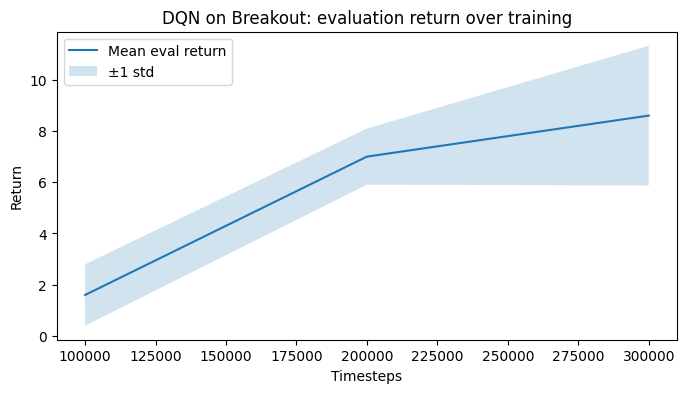

In [21]:
import numpy as np

eval_npz = os.path.join(LOG_DIR, "eval", "evaluations.npz")
data = np.load(eval_npz)
timesteps = data["timesteps"]
results = data["results"]  # shape: (n_evals, n_eval_episodes)
mean_returns = results.mean(axis=1)
std_returns  = results.std(axis=1)

def moving_avg(x, w=5):
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode="valid")

plt.figure(figsize=(8,4))
plt.plot(timesteps, mean_returns, label="Mean eval return")
plt.fill_between(timesteps, mean_returns-std_returns, mean_returns+std_returns, alpha=0.2, label="±1 std")
plt.title("DQN on Breakout: evaluation return over training")
plt.xlabel("Timesteps")
plt.ylabel("Return")
plt.legend()
plt.show()

# Optional smoothing
if len(mean_returns) >= 5:
    sm = moving_avg(mean_returns, w=5)
    ts = timesteps[4:]
    plt.figure(figsize=(8,4))
    plt.plot(ts, sm)
    plt.title("Smoothed eval return (moving average)")
    plt.xlabel("Timesteps")
    plt.ylabel("Return")
    plt.show()


In [ ]:
# Get a single observation from eval env (vectorized -> batch dim)
obs = eval_env.reset()

# SB3 policies provide utilities to convert obs to torch tensors
obs_tensor, _ = model.policy.obs_to_tensor(obs)

# Q-values from the online network
with model.policy.q_net.no_grad():
    q_values = model.policy.q_net(obs_tensor).cpu().numpy()[0]

greedy_action = int(np.argmax(q_values))
print("Q-values:", q_values)
print("Greedy action:", greedy_action)

plt.figure(figsize=(6,3))
plt.bar(np.arange(len(q_values)), q_values)
plt.title("Q(s, a) for current observation")
plt.xlabel("Action")
plt.ylabel("Q-value")
plt.show()


## 7) Visual: Greedy policy rollout video (“path” analogue)

For Atari, the cleanest “path” visualization is a short greedy gameplay clip.

We’ll record 1 episode with `VecVideoRecorder` using `deterministic=True` (greedy policy).


In [ ]:
# Create a fresh video env (1 env) and record
video_env = make_atari_env(
    env_id,
    n_envs=1,
    seed=SEED + 999,
    wrapper_kwargs=dict(terminal_on_life_loss=False),
)
video_env = VecFrameStack(video_env, n_stack=4)

video_folder = os.path.join(LOG_DIR, "videos")
os.makedirs(video_folder, exist_ok=True)

# Record the first episode
video_env = VecVideoRecorder(
    video_env,
    video_folder=video_folder,
    record_video_trigger=lambda step: step == 0,
    video_length=2_000,  # max frames to record
    name_prefix="dqn_greedy",
)

obs = video_env.reset()
episode_return = 0.0

for _ in range(2_000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = video_env.step(action)
    episode_return += float(reward)
    if done[0]:
        break

video_env.close()
print("Recorded greedy episode return:", episode_return)

# Find the created mp4
mp4s = [f for f in os.listdir(video_folder) if f.endswith(".mp4")]
mp4s.sort()
print("Videos:", mp4s[:3])

# Display the most recent
if mp4s:
    display(Video(os.path.join(video_folder, mp4s[-1]), embed=True))
